In [1]:
import findspark
findspark.init('/home/sdmohant/spark-3.0.0-bin-hadoop2.7')

In [2]:
import pyspark
from pyspark import SparkContext,SparkConf

In [3]:
from pyspark.sql import SparkSession

In [4]:
#spark = SparkSession.builder.appName("MyApp").getOrCreate()
#spark = SparkSession.builder.appName("MyName").getOrCreate()
conf = SparkConf().set("spark.cores.max", "16") \
    .set("spark.driver.memory", "16g") \
    .set("spark.executor.memory", "16g") \
    .set("spark.executor.memory_overhead", "16g") \
    .set("spark.driver.maxResultsSize", "0") \
    .set("spark.sql.shuffle.partitions","300")

sc = SparkContext(appName="politicalscimodel", conf=conf)
spark = SparkSession(sc)

/home/sdmohant/spark-3.0.0-bin-hadoop2.7/python/pyspark/context.py:220: DeprecationWarning: Support for Python 2 and Python 3 prior to version 3.6 is deprecated as of Spark 3.0. See also the plan for dropping Python 2 support at https://spark.apache.org/news/plan-for-dropping-python-2-support.html.
  DeprecationWarning)


In [5]:
from pyspark.sql.functions import isnan, count, col, when

In [6]:
polisciFOSID = 17744445

In [7]:
papers = spark.read.options(header = True, inferSchema = True,delimiter=',').csv("AllPapersFOS1.csv")

In [8]:
papers_filtered = papers.filter(col('FOS_ID').isin(['17744445']))

In [9]:
type(papers_filtered)

pyspark.sql.dataframe.DataFrame

In [10]:
papers_filtered.count()

381656

In [12]:
papers_pd = papers_filtered.toPandas()

In [15]:
papers_pd.rename(columns = {'CitationCount':'label'}, inplace = True)

## Comparison with Microsoft Estimations

In [13]:
import numpy as np

In [16]:
y_est = np.array(papers_pd["EstimatedCount"])
y_act = np.array(papers_pd["label"])

In [18]:
from sklearn.metrics import mean_squared_error
from sklearn import metrics

In [19]:
print('Mean Absolute Error of EstimatedCount:', metrics.mean_absolute_error(y_act, y_est))
print('Mean Squared Error of EstimatedCount:', metrics.mean_squared_error(y_act, y_est))
print('Root Mean Squared of with EstimatedCount:', np.sqrt(metrics.mean_squared_error(y_act, y_est)))

('Mean Absolute Error of EstimatedCount:', 1.1395314104848344)
('Mean Squared Error of EstimatedCount:', 964.8491704571657)
('Root Mean Squared of with EstimatedCount:', 31.06202135175954)


In [20]:
papers_pd_new = papers_pd.drop(["PaperID","EstimatedCount","PaperYear","Issue","Volume","FOS_ID"],axis=1)

In [21]:
papers_pd_new = papers_pd_new.reindex(columns=['Rank','ReferenceCount','PaperAge','min_FOSRank','max_FOSRank','IsJournal','max_FOSPaperCount',\
                               'min_FOSPaperCount','min_FOSCitationCount','max_FOSCitationCount','PaperRefCnt','label'])

In [22]:
papers_pd_new.columns

Index([u'Rank', u'ReferenceCount', u'PaperAge', u'min_FOSRank', u'max_FOSRank',
       u'IsJournal', u'max_FOSPaperCount', u'min_FOSPaperCount',
       u'min_FOSCitationCount', u'max_FOSCitationCount', u'PaperRefCnt',
       u'label'],
      dtype='object')

In [23]:
X = papers_pd_new.iloc[:, 0:11].values
y = papers_pd_new.iloc[:, 11].values

In [24]:
y[0:5]

array([38,  3,  0,  0,  1], dtype=int32)

In [25]:
papers_pd_new.head(2)

,Rank,ReferenceCount,PaperAge,min_FOSRank,max_FOSRank,IsJournal,max_FOSPaperCount,min_FOSPaperCount,min_FOSCitationCount,max_FOSCitationCount,PaperRefCnt,label
0,19877,0,8,9385,25000,1,3881737,4989,45017,8935700,0,38
1,22046,13,9,8034,25000,1,3881737,3569,60738,8935700,0,3


In [26]:
from sklearn.model_selection import KFold

In [27]:
kf = KFold(n_splits=5)
kf.get_n_splits(X, y)

5

In [28]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np

In [29]:
rmse_list = []
for train_index, test_index in kf.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    regressor = RandomForestRegressor(n_estimators=100, max_depth=30, random_state=0)
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    rmse_list.append(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    

('Mean Absolute Error:', 0.8782944867568582)
('Mean Squared Error:', 52.73461286845309)
('Root Mean Squared Error:', 7.2618601520859025)
('Mean Absolute Error:', 0.9217789245098185)
('Mean Squared Error:', 134.29769636675752)
('Root Mean Squared Error:', 11.58868829362312)
('Mean Absolute Error:', 0.8692307637502127)
('Mean Squared Error:', 45.73936369002662)
('Root Mean Squared Error:', 6.763088324872493)
('Mean Absolute Error:', 0.9164921574244668)
('Mean Squared Error:', 77.2424384695314)
('Root Mean Squared Error:', 8.788767744657461)
('Mean Absolute Error:', 0.9536760796386946)
('Mean Squared Error:', 234.27003441076286)
('Root Mean Squared Error:', 15.305882346691511)


In [30]:
rmse_sum = 0
for index in range(0,5):
    rmse_sum = rmse_sum + rmse_list[index]
mean_rmse = rmse_sum/5
print("Mean RMSE is :",mean_rmse)

('Mean RMSE is :', 9.941657372386098)


## XGBoost Regression

In [31]:
import xgboost as xgb

In [32]:
kf = KFold(n_splits=5)
kf.get_n_splits(X)

5

In [33]:
rmse_list = []
for train_index, test_index in kf.split(X,y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    regressor = xgb.XGBRegressor(
                n_estimators=100,
                reg_lambda=1,
                gamma=0,
                max_depth=20
                )
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    rmse_list.append(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('Mean Absolute Error of XGBoost Kfold:', metrics.mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error of XGBoost Kfold:', metrics.mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error of XGBoost Kfold:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

('Mean Absolute Error of XGBoost Kfold:', 0.9483780790709327)
('Mean Squared Error of XGBoost Kfold:', 80.87374905897663)
('Root Mean Squared Error of XGBoost Kfold:', 8.992983323623848)
('Mean Absolute Error of XGBoost Kfold:', 0.9692458536077799)
('Mean Squared Error of XGBoost Kfold:', 146.7434590835294)
('Root Mean Squared Error of XGBoost Kfold:', 12.113771464062271)
('Mean Absolute Error of XGBoost Kfold:', 0.9226887443561621)
('Mean Squared Error of XGBoost Kfold:', 81.084587245579)
('Root Mean Squared Error of XGBoost Kfold:', 9.004698065209016)
('Mean Absolute Error of XGBoost Kfold:', 0.9642349673075574)
('Mean Squared Error of XGBoost Kfold:', 105.89800726178203)
('Root Mean Squared Error of XGBoost Kfold:', 10.290675743690597)
('Mean Absolute Error of XGBoost Kfold:', 0.9934985412399203)
('Mean Squared Error of XGBoost Kfold:', 244.0119943837903)
('Root Mean Squared Error of XGBoost Kfold:', 15.620883277964479)


In [34]:
rmse_sum = 0
for index in range(0,5):
    rmse_sum = rmse_sum + rmse_list[index]
mean_rmse = rmse_sum/5
print("Mean RMSE is :",mean_rmse)

('Mean RMSE is :', 11.204602374910042)


In [36]:
importances = regressor.feature_importances_

In [37]:
for i,v in enumerate(importances):
	print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.40027
Feature: 1, Score: 0.06714
Feature: 2, Score: 0.11837
Feature: 3, Score: 0.06573
Feature: 4, Score: 0.10971
Feature: 5, Score: 0.02282
Feature: 6, Score: 0.00041
Feature: 7, Score: 0.12041
Feature: 8, Score: 0.07291
Feature: 9, Score: 0.01405
Feature: 10, Score: 0.00818


In [38]:
import pandas as pd

In [40]:
featureslist = papers_pd_new.columns 

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline

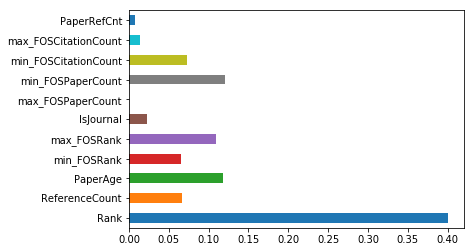

In [43]:
(pd.Series(importances, index=featureslist[0:11]).plot(kind='barh')) 